In [442]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp
from autograd import grad, jacobian
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city

# Pennylane numpy
from pennylane import numpy as pnp 

In [443]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev1 = qml.device('default.qubit', wires = 2)
dev2 = qml.device('default.qubit', wires = 3)

# Define Hamiltonian for quantum computations
# H1 = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H1 = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H2 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])
H3 = qml.Hamiltonian(coeffs=[-0.5, -0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)])

In [444]:
# @qml.qnode(dev, interface='autograd')
# def bell_state():
#     # Bell state for 2-qubit
#     qml.Hadamard(wires=0)
#     qml.CNOT(wires=[0, 1])
    
#     return qml.density_matrix(wires=[0, 1])
    
# @qml.qnode(dev, interface='autograd')
# def interaciton(phi):
#     # Get density matrix from the bell_state
#     density_matrix = bell_state()
#     qml.QubitDensityMatrix(density_matrix, wires=[0, 1])

#     # Time Evolution with z-z interaction
#     # qml.ApproxTimeEvolution(hamiltonian, phi, 1)
#     qml.ApproxTimeEvolution(H1, phi, 1)
    
#     # return qml.density_matrix(wires=[0, 1])
#     return qml.probs(wires=[0, 1])

# fig, ax = qml.draw_mpl(bell_state)()

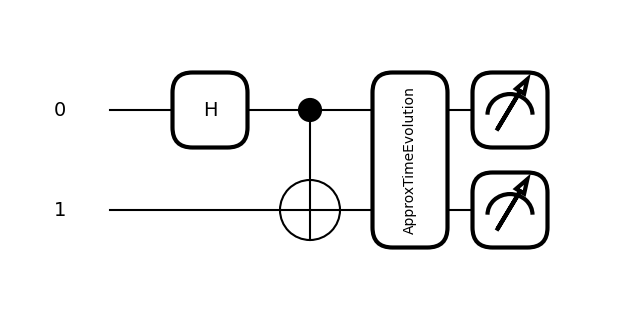

In [445]:
@qml.qnode(dev1, interface='autograd')
def circuit(phi):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    
    qml.ApproxTimeEvolution(H2, phi, 1)
    
    return qml.state()

fig, ax = qml.draw_mpl(circuit)(np.pi)

In [446]:
# plot_state_city(circuit(), color=['midnightblue', 'crimson'], title = "Bell state")

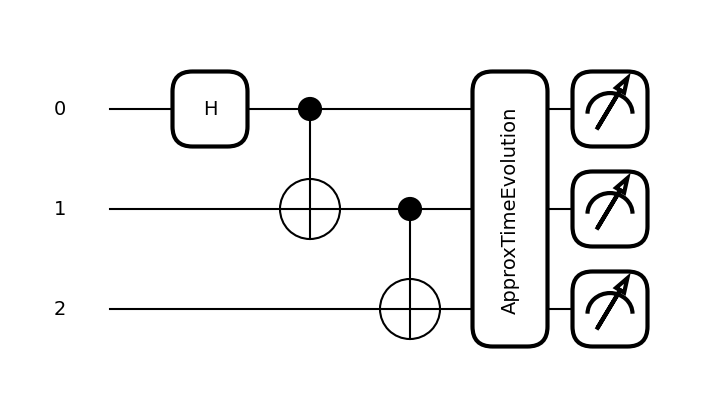

In [447]:
@qml.qnode(dev2, interface='autograd')
def circuit_3(phi):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    
    qml.ApproxTimeEvolution(H3, phi, 1)
    
    return qml.state()

fig, ax = qml.draw_mpl(circuit_3)(np.pi)

In [448]:
def fisher_information(phi, type, num_qubit):
    phi_current = pnp.array([phi], requires_grad = True)
    
    if type == 'classical':
        if num_qubit == 2:
            return qml.qinfo.classical_fisher(circuit)(phi_current[0])
        else:
            return qml.qinfo.classical_fisher(circuit_3)(phi_current[0])
    else:
        if num_qubit == 2:
            return qml.qinfo.quantum_fisher(circuit)(phi_current[0])
        else:
            return qml.qinfo.quantum_fisher(circuit_3)(phi_current[0]) 


In [449]:
def plot_fisher(type, num_qubit):
    PHI = np.arange(0, 3*np.pi, 1e-2)
    Data = np.zeros((len(PHI), 2))
    Data[:,0] = PHI.squeeze()

    for phi_idx, phi in enumerate(PHI):
        Data[phi_idx, 1] = fisher_information(phi, type, num_qubit)
        
    plt.plot(Data[:, 0], Data[:,1], label = f'{num_qubit}-qubit')
    plt.title(f'Bell state')
    plt.xlabel('Time')
    plt.ylabel('QFI')
    plt.grid()
    plt.legend()

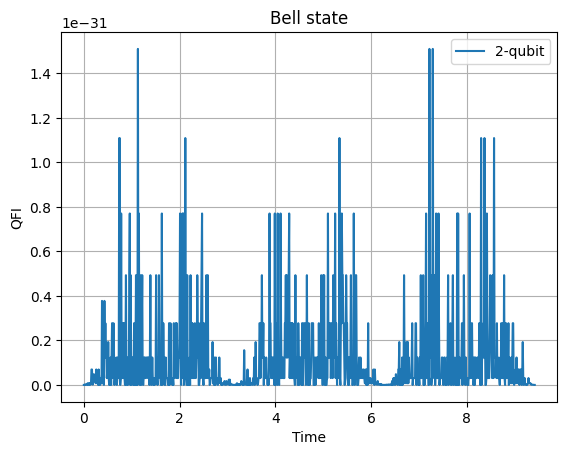

In [450]:
plot_fisher('classical', 2)

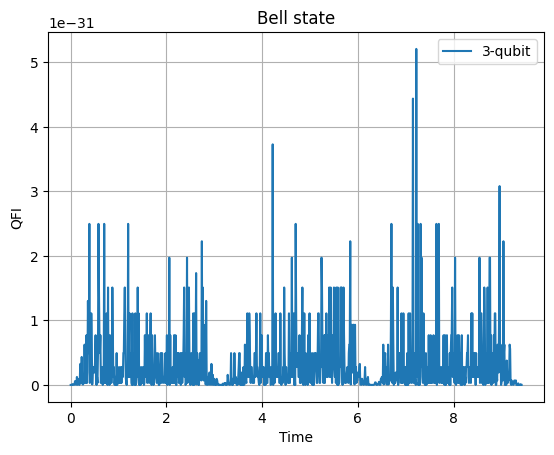

In [451]:
plot_fisher('classical', 3)

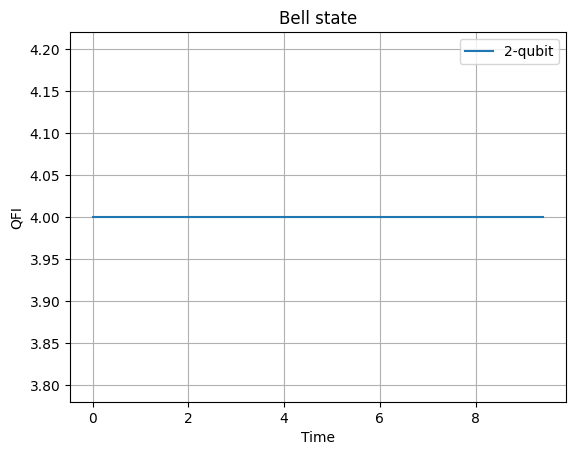

In [452]:
plot_fisher('quantum', 2)

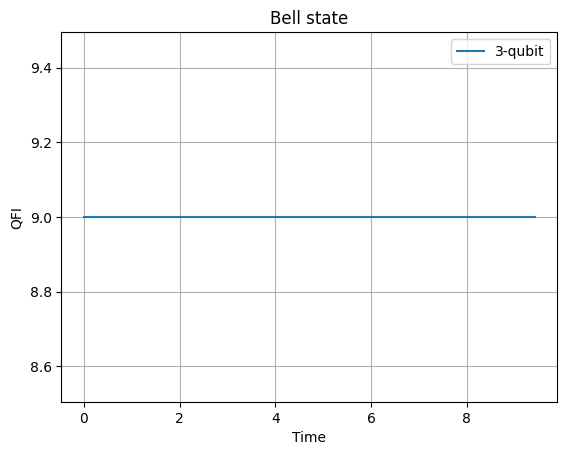

In [453]:
plot_fisher('quantum', 3)